In [1]:
import Pkg; Pkg.activate(".."); Pkg.instantiate();

  Activating project at `c:\Users\matti\Documents\TUe\Thesis\ThesisParallelMP`


In [2]:
using Distributed

In [3]:
addprocs(8);

In [4]:
@everywhere using RxInfer, Random, StatsPlots, LinearAlgebra, ProgressMeter, PGFPlotsX, Revise

In [5]:
@everywhere includet("../distributed.jl")

In [6]:
pgfplotsx()

Plots.PGFPlotsXBackend()

In [7]:
n = 200  # Number of coin flips
p = 0.75 # Bias of a coin

distribution = Bernoulli(p)
dataset      = float.(rand(Bernoulli(p), n))
prior = Beta(2.0, 6.0)

Beta{Float64}(α=2.0, β=6.0)

In [8]:
@model function coin_model(n, prior, prod_strategy, pipeline, meta, prod_constraint)

    y = datavar(Float64, n)
	θ = randomvar() where { prod_strategy = prod_strategy, prod_constraint = prod_constraint }

    θ ~ prior

    for i in 1:n
        y[i] ~ Bernoulli(θ) where { pipeline = pipeline, meta = meta  }
    end

end

In [9]:
@everywhere begin
    struct MyCustomRule
        size::Int
    end

    function factorial(n)
        if n == 0 || n == 1
            return 1
        else
            return factorial(n - 1) + factorial(n - 2)
        end
    end

    @rule Bernoulli(:p, Marginalisation) (q_out::PointMass, meta::MyCustomRule) = begin
        @logscale -log(2)
        r = mean(q_out)
        s = factorial(meta.size) / 10^8
        return Beta(one(r) + r, 2one(r) - r + s)
    end
end

In [10]:
struct MyCustomProd
    size::Int
end

function RxInfer.BayesBase.prod(custom::MyCustomProd, left, right)
    r = mean(left)
	s = factorial(custom.size) / 10^8
    return prod(GenericProd(), Beta(one(r) + r, 2one(r) - r + s), right)
end

function RxInfer.BayesBase.prod(custom::MyCustomProd, left::Missing, right)
    return right
end

In [11]:
function execute_benchmark(f::F, n = 1000) where { F }

    # For the compilation
    f()

    GC.gc()
    GC.gc(true)

    times = Vector{Float64}(undef, n)

    for i in 1:n
        times[i] = f()
    end

    return times
end

execute_benchmark (generic function with 2 methods)

In [12]:
function benchmark_rule(meta; n = 1000)
    times = Vector{Float64}(undef, n)

    for i in 1:n
        start_time = time_ns()
        @call_rule Bernoulli(:p, Marginalisation) (q_out = PointMass(1), meta = meta)
        times[i] = time_ns() - start_time
    end

    return times / 1000
end

benchmark_rule (generic function with 1 method)

In [13]:
function prepare_benchmark(prod, pipeline, dataset, prior, meta, prod_constraint, niterations = 100)
    return () -> begin
        timing = Ref(0.0)
        current_iter = Ref(0.0)
        infer(
            model = coin_model(length(dataset), prior, prod, pipeline, meta, prod_constraint),
            data  = (y = dataset, ),
            callbacks = (
                before_iteration = (model, iteration) -> begin
                    current_iter[] = time_ns()
                    return false
                end,
                after_iteration = (model, iteration) -> begin
                    current_iter[] = time_ns() - current_iter[]
                    timing[] = timing[] + current_iter[]
                    return false
                end
            ),
            iterations = niterations
        )
        return timing[]
    end
end

prepare_benchmark (generic function with 2 methods)

In [14]:
function run_rule_benchmark(combinations, sizes; nsamples = 1, dataset = dataset, prior = prior, niterations = 100)
    return @showprogress map(sizes) do size

        results = Dict()
        results[:rule] = benchmark_rule(MyCustomRule(size))

        for (key, combination) in combinations
            _b_combination = prepare_benchmark(combination[1], combination[2], dataset, prior, MyCustomRule(size), nothing, niterations)
            results[key] = execute_benchmark(_b_combination, nsamples)
        end

        return (size, results)
    end
end

run_rule_benchmark (generic function with 1 method)

In [15]:
combinations = [
    :sequential => (nothing, nothing),
    :parallel_dist => (CustomProdStrategy(dist_prod), nothing),
    :parallel_pipeline => (nothing, DistributedPipelineStage()),
]

3-element Vector{Pair{Symbol, Tuple{Any, Any}}}:
        :sequential => (nothing, nothing)
     :parallel_dist => (CustomProdStrategy{typeof(dist_prod)}(dist_prod), nothing)
 :parallel_pipeline => (nothing, DistributedPipelineStage())

In [16]:
function plot_rule_benchmark(combinations, sizes, n, niterations)
    rule_results = run_rule_benchmark(combinations, sizes; dataset=float.(rand(distribution, n)), niterations = niterations);

    sizes = getindex.(rule_results, 1)
    benchmarks = getindex.(rule_results, 2)
    names = [first.(combinations); :rule]

    points = map(names) do name
        name => minimum.(getindex.(benchmarks, name))
    end |> Dict

    p = plot(
        xaxis = :log,
        yaxis = :log,
        legend = false,
        xlabel = "Rule computation time [μs]",
        ylabel = "Relative speed [-]",
        yticks = ([1:8;], [string(a) for a in 1:8]),
        ylim = (0.3, 8),
        gridalpha = 0.3,
        title = "N = $n",
    )

    for (key, values) in pairs(points)
        if key != :rule
            plot!(p, points[:rule], points[:sequential] ./ values)
        end
    end

    return p
end

plot_rule_benchmark (generic function with 1 method)

In [17]:
names = first.(combinations)

ordered_combinations = map(names) do name
    name => 0
end |> Dict;

In [18]:
sizes = 20:2:32
niterations = 1

p1 = plot_rule_benchmark(combinations, sizes, 48, niterations)
p2 = plot_rule_benchmark(combinations, sizes, 480, niterations);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:48
Progress: 100%|█████████████████████████████████████████| Time: 0:04:04


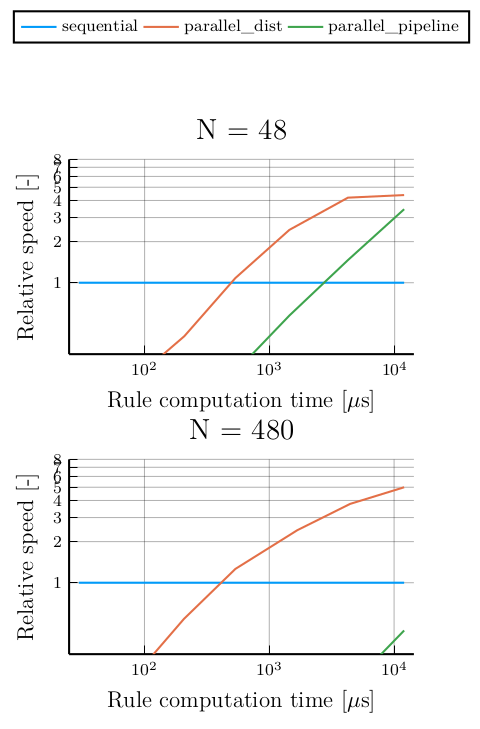

In [19]:
leg = plot(
    framestyle = :none,
    legend = :top,
    #legend_column = length(combinations),
    legend_column = 3
)

for (key, values) in pairs(ordered_combinations)
    plot!(leg, [0, 0], [0, 0], label = string(key))
end
l = @layout [a{0.2h}; b; c]

plot(
    leg, p1, p2,
    layout = l,
    size = (300, 500),
)

In [20]:
savefig("plots/coin_toss_dist.tikz")

"c:\\Users\\matti\\Documents\\TUe\\Thesis\\ThesisParallelMP\\benchmarks-distributed\\plots\\coin_toss_dist.tikz"